In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warehouse
import seaborn as sb


import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]



Read Data
---

In [2]:
import os
import sys


ga_df = None
greedy_df = None
cws_df = None
tabu_df = None

with open("../results/ga.results", "r") as ga_file,\
     open("../results/greedy.results", "r") as greedy_file,\
     open("../results/cws.results", "r") as cws_file,\
     open("../results/tabu.results", "r") as tabu_file:
    ga_df = warehouse.read(ga_file.read(), type="standard")
    greedy_df = warehouse.read(greedy_file.read(), type="standard")
    cws_df = warehouse.read(cws_file.read(), type="standard")
    tabu_df = warehouse.read(tabu_file.read(), type="standard")
    
ga_work_df = None
greedy_work_df = None
cws_work_df = None
tabu_work_df = None

with open("../results/ga_robots.results", "r") as ga_file,\
     open("../results/greedy_robots.results", "r") as greedy_file,\
     open("../results/cws_robots.results", "r") as cws_file,\
     open("../results/tabu_robots.results", "r") as tabu_file:
    ga_work_df = warehouse.read(ga_file.read(), type="work")
    greedy_work_df = warehouse.read(greedy_file.read(), type="work")
    cws_work_df = warehouse.read(cws_file.read(), type="work")
    tabu_work_df = warehouse.read(tabu_file.read(), type="work")


print(os.path.abspath(os.pardir))

/home/jonas/notebooks/warehouse_cpp


Group data
---

In [3]:
ga_G = ga_df.groupby("group")
ga_groups = list(ga_G.groups.keys())

greedy_G = greedy_df.groupby("group")
greedy_groups = list(greedy_G.groups.keys())

cws_G = cws_df.groupby("group")
cws_groups = list(cws_G.groups.keys())

tabu_G = tabu_df.groupby("group")
tabu_groups = list(tabu_G.groups.keys())


ga_groups.sort()
greedy_groups.sort()
cws_groups.sort()
tabu_groups.sort()

## Work groups


ga_work_G = ga_work_df.groupby("group")
ga_work_groups = list(ga_work_G.groups.keys())

greedy_work_G = greedy_work_df.groupby("group")
greedy_work_groups = list(greedy_work_G.groups.keys())

cws_work_G = cws_work_df.groupby("group")
cws_work_groups = list(cws_work_G.groups.keys())

tabu_work_G = tabu_work_df.groupby("group")
tabu_work_groups = list(tabu_work_G.groups.keys())

ga_work_groups.sort()
greedy_work_groups.sort()
cws_work_groups.sort()
tabu_work_groups.sort()

available_groups = ga_groups
available_work_groups = ga_work_groups

Score Distribution
---

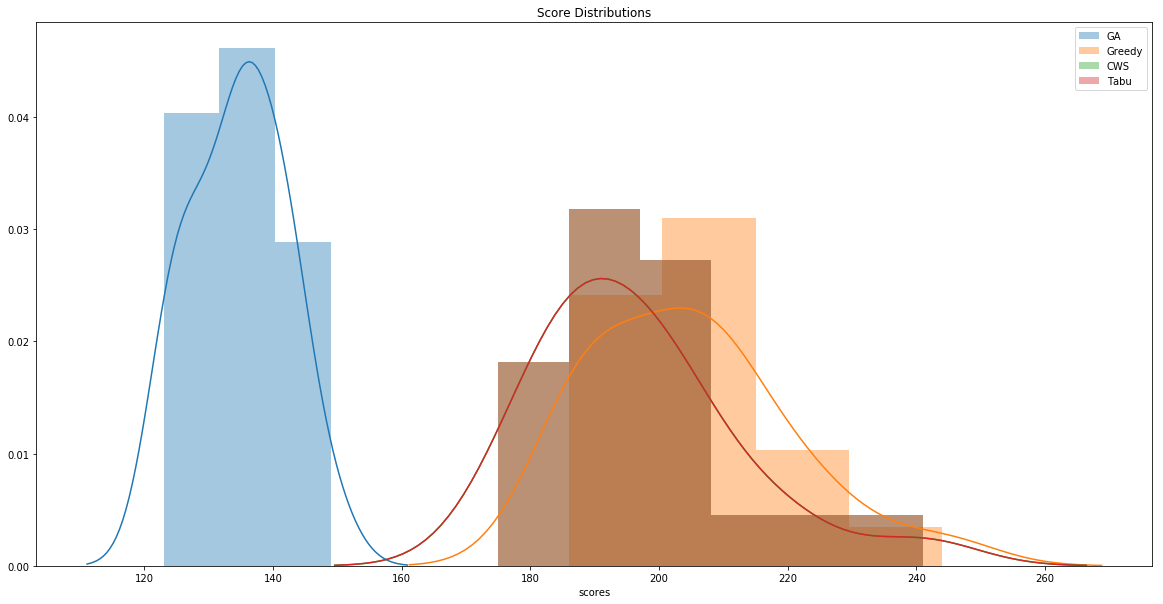

In [4]:
fig, ax = plt.subplots(1, figsize=(20, 10))

group = 2

try:
    ga_data = ga_G.get_group(ga_groups[group])
    sb.distplot(ga_data["scores"], label="GA", ax=ax)
    ax.legend()
except Exception as e:
    print("Failed to plot GA %s" % str(e))

try:
    greedy_data = greedy_G.get_group(greedy_groups[group])
    sb.distplot(greedy_data["scores"], label="Greedy", ax=ax)
    ax.legend()
except Exception as e:
    print("Failed to plot greedy %s" % str(e))

try:
    cws_data = cws_G.get_group(cws_groups[group])
    sb.distplot(cws_data["scores"], label="CWS", ax=ax)
    ax.legend()
except Exception as e:
    print("Failed to plot cws %s" % (str(e)))

try:
    tabu_data = tabu_G.get_group(tabu_groups[group])
    sb.distplot(tabu_data["scores"], label="Tabu", ax=ax)
    ax.legend()
except Exception as e:
    print("Failed to plot tabu %s" % str(e))

ax.set_title("Score Distributions")

fig.savefig("outputs/big_warehouse_score_distribution.pdf", bbox_inches='tight')

plt.show()

Score Distribution Development
---

Failed to plot group 15 for Greedy: '15'
Failed to plot group 16 for Greedy: '16'
Failed to plot group 17 for Greedy: '17'
Failed to plot group 18 for Greedy: '18'
Failed to plot group 19 for Greedy: '19'
Failed to plot group 15 for CWS: '15'
Failed to plot group 16 for CWS: '16'
Failed to plot group 17 for CWS: '17'
Failed to plot group 18 for CWS: '18'
Failed to plot group 19 for CWS: '19'
Failed to plot group 15 for Tabu: '15'
Failed to plot group 16 for Tabu: '16'
Failed to plot group 17 for Tabu: '17'
Failed to plot group 18 for Tabu: '18'
Failed to plot group 19 for Tabu: '19'


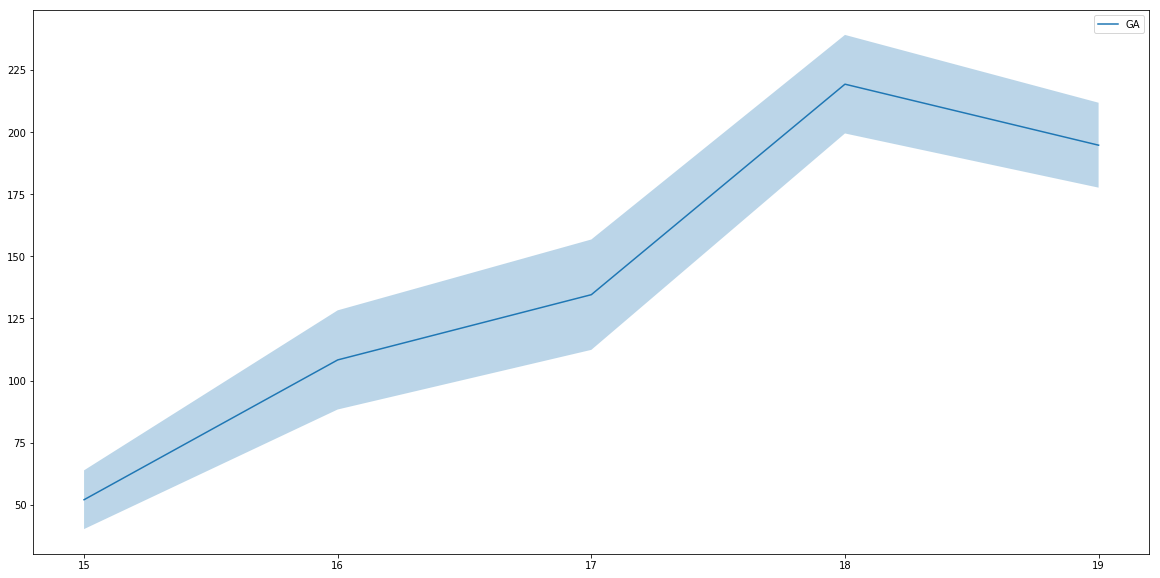

In [5]:
fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_G),
    ("Greedy", greedy_G),
    ("CWS", cws_G),
    ("Tabu", tabu_G)
]

for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            means.append(g["scores"].mean())
            stds.append(g["scores"].std())
        except Exception as e:
            print("Failed to plot group %s for %s: %s" % (str(group), name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend()
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)


        
fig.savefig("outputs/mean_and_variance_score_development.pdf", bbox_inches='tight')

plt.show()       


Workload Distributions
---

Failed to plot group 15 for Greedy - '15'
Failed to plot group 16 for Greedy - '16'
Failed to plot group 17 for Greedy - '17'
Failed to plot group 18 for Greedy - '18'
Failed to plot group 19 for Greedy - '19'
Failed to plot group 15 for CWS - '15'
Failed to plot group 16 for CWS - '16'
Failed to plot group 17 for CWS - '17'
Failed to plot group 18 for CWS - '18'
Failed to plot group 19 for CWS - '19'
Failed to plot group 15 for Tabu - '15'
Failed to plot group 16 for Tabu - '16'
Failed to plot group 17 for Tabu - '17'
Failed to plot group 18 for Tabu - '18'
Failed to plot group 19 for Tabu - '19'


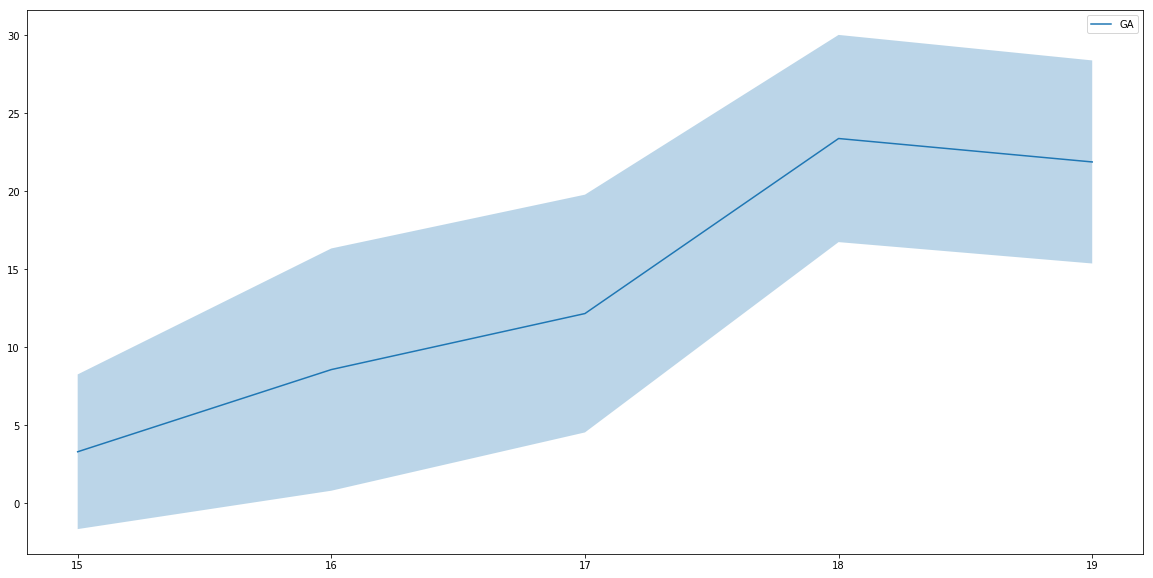

In [6]:
import ast

fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_work_G),
    ("Greedy", greedy_work_G),
    ("CWS", cws_work_G),
    ("Tabu", tabu_work_G)
]

for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            mmeans = []
            for item in g["data"]:
                arr = np.array(ast.literal_eval(item))
                mmeans.append(arr.std())
            mmeans = np.array(mmeans)
            means.append(mmeans.mean())
            stds.append(mmeans.std())
        except Exception as e:
            print("Failed to plot group %s for %s - %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend()
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)


        
fig.savefig("outputs/mean_and_std_score_development.pdf", bbox_inches='tight')

plt.show()       

Complexity Distributions
---

['capacity', 'computation', 'group', 'packages', 'robots', 'scores', 'seed']
['capacity', 'computation', 'group', 'packages', 'robots', 'scores', 'seed']
['capacity', 'computation', 'group', 'packages', 'robots', 'scores', 'seed']
['capacity', 'computation', 'group', 'packages', 'robots', 'scores', 'seed']
['capacity', 'computation', 'group', 'packages', 'robots', 'scores', 'seed']


TypeError: not all arguments converted during string formatting

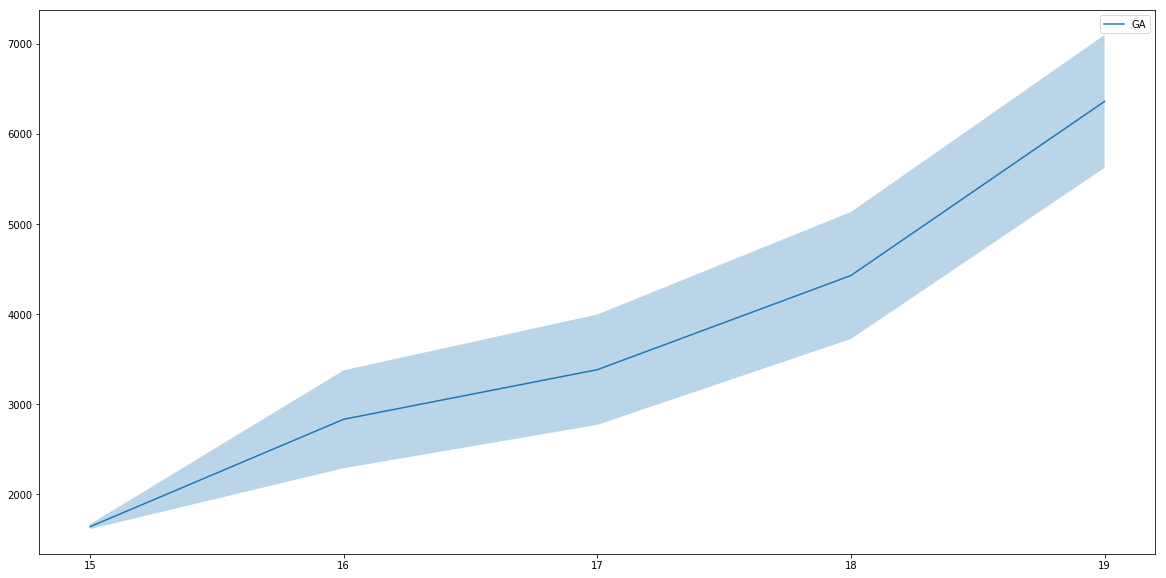

In [7]:
fig, ax = plt.subplots(1, figsize=(20, 10))

Gs = [
    ("GA", ga_G),
    ("Greedy", greedy_G),
    ("CWS", cws_G),
    ("Tabu", tabu_G)
]

for name, G in Gs:
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            
            print(list(g))
            means.append(g["computation"].mean())
            stds.append(g["computation"].std())
        except Exception as e:
            print("Failed to plot group %s for %s: %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend()
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)


        
fig.savefig("outputs/computation_mean_std_development.pdf", bbox_inches='tight')

plt.show()       
